# ML Adaptive Beamformer for ULA
---


## Quiescent Beamforming

First as a background, the quiescent (e.g. static) case of a linear array will be considered. The non-dynamic beamforming weights will be derived for a given steering direction. We will also show the basis of Digital Beamforming (DBF) with these static weights.

Lets also import the necessary Python packages and libraries now too:

In [1]:
import os
import pathlib
import random
from IPython.display import Image, display

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.constants

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

### Uniform Linear Array Parameters & System Constants

Here we are dealing with a linear phased array system.

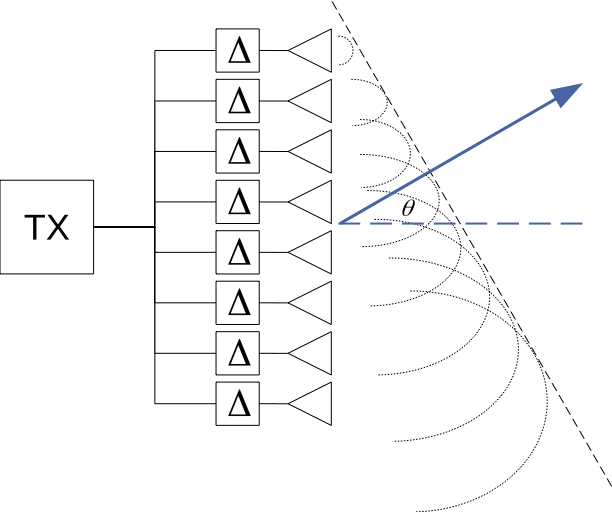

In [2]:
display(Image(filename='../../02_abf_background/phased_array.png', width=400))

Set the parameters and system constants for the Uniform Linear Array (ULA), including the number of antenna elements, $N$, the operating/carrier frequency, $f_{c}$, and the desired plane wave _angle of arrival_ (AoA) relative to boresight, $\theta_{0}$:

> NOTE: to prevent grating lobes, the antenna element spacing should be $\frac{d}{\lambda}=0.5$

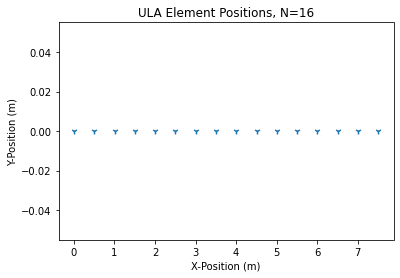

In [3]:
N       = 16    # number of elements in ULA
fc      = 300e6 # RF carrier frequency (assuming narrowband here)
fs      = 1e9   # IF/direct sampling frequency
theta   = -10   # desired signal Angle of Arrival (AoA) in degrees
SNR     = 1     # element SNR (linear units)
noiseP  = 1     # noise power (linear units)
spacing = 0.5   # d/wavelength element spacing (0.5 = half-wavelength spacing)

wavelength = fc/scipy.constants.c
# generate array of antenna element positions
antPos = np.linspace(0,N-1,N)*wavelength*spacing
plt.scatter(antPos, np.zeros(N), marker='1')
plt.title("ULA Element Positions, N=%i" % N)
plt.ylabel("Y-Position (m)")
plt.xlabel("X-Position (m)")
plt.show()

### Spatial Response

For narrowband signals, the complex spatial response vector is formed from the baseband envelope phasor at each ULA element, which is a function of AoA $\theta_{0}$, operating wavelength $\lambda$ , and the elemental spacing $d$ [2]:
$$ s_{n} = e^{j 2\pi (n-1) \frac{d}{\lambda} \sin{\theta_{0}} }  \quad 0 \leq n \leq N - 1 $$

In [4]:
# given wavelength (same units as ula_pos_vec), azimuth direction of wave impinging on ULA, and N-element antenna position vector
def narrowband_spatial_phasor(wavelen, theta_deg, ula_pos_vec):
    cmplx_pos = (1j*2*np.pi/wavelen)*ula_pos_vec.T
    sn = np.exp(cmplx_pos*np.sin(np.deg2rad(theta_deg)))
    return sn
    
s = narrowband_spatial_phasor(wavelength, theta, antPos)

Compute hypothesis of steering vectors in sine space for quiescent beamforming weights. Plot the weight response over sine space by testing weight magnitude at each look direction in vector `u`, from $-90^{\circ}$ to $90^{\circ}$

In [5]:
numHyp = 400 # number of direction hypothesis to compute
u = np.linspace(-1,1,numHyp)
# create matched filter (beam weights) for quiescent case (no interference)
wq = np.exp(np.outer((1j*2*np.pi/wavelength)*antPos.T, u))
# unit normalize filter weights
mag = wq * wq.conj()
wq = wq / mag.sum(axis=0) # sum over columns (each channel, per hypothesis)

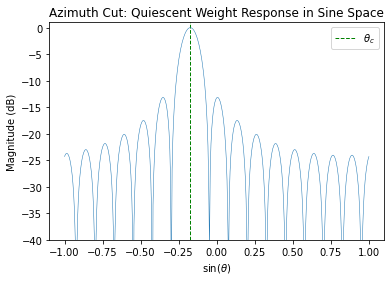

In [6]:
yq = np.inner(wq.conj().T, s)
fig, ax = plt.subplots()
ax.plot(u, 20*np.log10(np.abs(yq)), linewidth=0.5)
ax.set(xlabel=r'$\sin(\theta)$',
       ylabel='Magnitude (dB)',
       title='Azimuth Cut: Quiescent Weight Response in Sine Space')
ax.set_ylim([-40, 1]) # set sensible magnitude limits since edges near 0 gain
ax.vlines(np.sin(np.deg2rad(theta)), -40, 1, colors='green', linestyles='dashed', label=r'$\theta_{c}$', linewidth=1)
ax.legend()
plt.show()

#### Windowing Quiescent Weights

[Windowing](https://en.wikipedia.org/wiki/Window_function) can be applied to weights as well to adjust sidelobes, such as applying an $M$-point Hamming window which is weighted by:
$$ w(n) = 0.54 - 0.46\cos(\frac{2\pi n}{M - 1}) \quad 0 \leq n \leq M - 1 $$

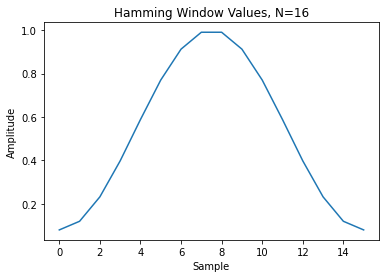

In [7]:
window = np.hamming(N)
plt.plot(window)
plt.title("Hamming Window Values, N=%i" % N)
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

As expected, the great reduction in sidelobes causes an increase in mainlobe width compared to non-windowed weights. Windowing is always a balance between sidelobe performance and mainlobe width.

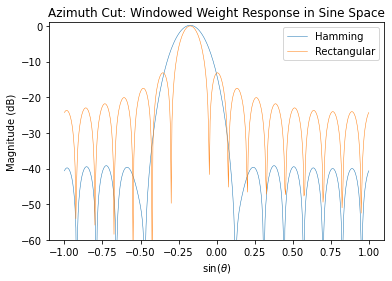

In [8]:
w_ham = window * s
# normalize Hamming windowed weights to 0dB by giving 6dB gain (mainlobe is attenuated by 6dB)
w_ham *= 10.0**(6.0/20.0)
y_ham = np.inner(wq.conj().T, w_ham)
fig, ax = plt.subplots()
ax.plot(u, 20*np.log10(np.abs(y_ham)), u, 20*np.log10(np.abs(yq)), linewidth=0.5)
ax.set(xlabel=r'$\sin(\theta)$',
       ylabel='Magnitude (dB)',
       title='Azimuth Cut: Windowed Weight Response in Sine Space')
ax.set_ylim([-60, 1]) # set sensible magnitude limits since edges near 0 gain
ax.legend(['Hamming', 'Rectangular'])
plt.show()

The non-windowed (rectangular) null-to-null width of a ULA can be found by [2]:
$$ \theta_{MB} = 2\sin^{-1}\left [ \frac{\lambda}{Nd} - \sin(\theta_{0}) \right ] $$

In [9]:
theta_MB = 2*np.rad2deg( np.arcsin( 1/(N*spacing) - np.sin(np.deg2rad(theta)) ))
print('Mainlobe null-to-null width of rectangular window is %f degrees' % theta_MB)

Mainlobe null-to-null width of rectangular window is 34.752855 degrees


### Response to Off-Angle Interference

Here we create an interference signal at a different angle of arrical than our intended signal.

In [10]:
def shifted_tone(amplitude, freq, time_vec, spatial_phasor_vec):
    phasor_tone = amplitude * np.exp(1j*2*np.pi*freq*time_vec)
    phasor_shft = np.outer(phasor_tone, np.matrix(spatial_phasor_vec)).T
    return phasor_shft

In [11]:
thetaInf = 30 # intereference signal Angle of Arrival (AoA) in degrees
fInf = 0.9*fc # interference signal carrier frequency (assuming narrowband)
wavelengthInf = fInf/scipy.constants.c

M = N*128 # M received samples/ch, where M ≥ N channels to form MxN sample matrix
# time vector based on sampling frequency
t = np.linspace(1,M,M)/fs
t.shape = (1,M) # force transpose

# phase shift received ideal waveform w/o noise or interference
rx_shft = shifted_tone(np.sqrt(SNR*noiseP), fc, t, s)

# calculate phase shift of interefence wave over ULA
sInf = narrowband_spatial_phasor(wavelengthInf, thetaInf, antPos)
# interference waveform with interference phase shift based on its frequency (again assumed narrowband)
infRx_shft = shifted_tone(np.sqrt(SNR*noiseP), fInf, t, sInf)

# create random RX noise (thermal, environmental, etc.) across array which is Gaussian
# in distribution: https://en.wikipedia.org/wiki/Johnson%E2%80%93Nyquist_noise
infNoise = np.sqrt(noiseP/2) * (np.random.randn(N,M) + 1j*np.random.randn(N,M))

# add interference & noise to create combined, synthetic RX waveform
rx_all = rx_shft + infNoise + infRx_shft

Next, we show a comparison between no digital beamforming and a simple DBF with quiescent weights in the presence of an interferer and noise.

Notice that since the interference is off angle, and the basic sum averaging case is the same as having quiescent weights for a look directly at boresight (0 degrees), the 30 degree interference is seen but at a lower power since it falls within a sidelobe (see weight plots above).

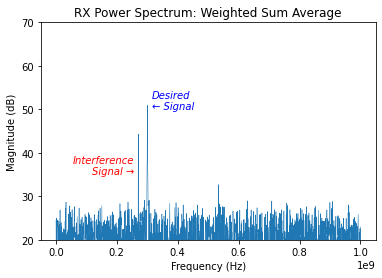

In [12]:
# perform basic sum averaging across all channels for "no DBF" case
nonDBF = np.sum(rx_all, axis=0)/N

# plot FFT power spectrum of RX signals
freqBin = np.linspace(1,M,M)*(fs/M)
nonDBF_PSD = 20*np.log10(np.abs(np.fft.fft(nonDBF)))
fig, ax = plt.subplots()
ax.plot(freqBin, nonDBF_PSD, linewidth=0.5)
ax.set(xlabel='Frequency (Hz)',
       ylabel='Magnitude (dB)',
       title='RX Power Spectrum: Weighted Sum Average')
ax.text(fInf*.95, 35, 'Interference\nSignal →', horizontalalignment='right', color='red', fontstyle='italic')
ax.text(fc*1.05, 50, 'Desired\n← Signal', color='blue', fontstyle='italic')
ax.set_ylim([20, 70])
plt.show()

## MVDR Beamforming

Minimum Variance Distortionless Response (MVDR) minimizes the total array power while maintaining unity gain for signals in the desired direction [1]. Essentially this process minimizes noise and off-angle interference signals' powers by placing spatial nulls at certain array angles (also known as "null steering"). The MVDR beamforming weights, $w$, can be calculated by:
$$ w = \frac{ \boldsymbol{S}^{-1} \boldsymbol{v_{0}} } { \boldsymbol{v_{0}}^{H} \boldsymbol{S}^{-1} \boldsymbol{v_{0}} } $$
where $\boldsymbol{S}$ is the spatial sample covariance matrix, and $\boldsymbol{v_{0}}$ is the complex steering vector representing the phase shifts across the array to form the desired steering direction.

In [13]:
# Given N channels, with M samples per channel, and M ≥ N
#   input args: X = 2D input sample array(N elements x M samples)
#      returns: S = sample covariance matrix (N x N)
def calc_covar_matrix(X):
    # form covariance matrix of input samples
    S = X @ X.T.conj()
    return S

# Given N channels, with M samples per channel, and M ≥ N
#   input args: S = sample covariance matrix (N x N), sv = steering vector(N x 1)
#      returns: w = MVDR weight col vector(N x 1)
def MVDR_beamform(S, sv):
    # compute weight vector using steering vector and inverting matrix
    # solves for x in Ax=b, where A is the covariance sample matrix, and b is the steering vector
    wp, resid, rank, s = np.linalg.lstsq(S, sv, rcond=None)
    # normalize weight response
    w = wp/(np.matrix(sv).H * wp)
    return w

# input args: X = 2D input sample array(N samples x M elements), w = weight col vector(N x 1)
# returns: Y = output beam row vector(1 x M)
def DBF_apply(X, w):
    # form output beam with MVDR computed weights
    # TODO: why does below work but not -> Y = X * np.conjugate(w)
    Y = np.zeros(M) + 1j*np.zeros(M)
    for i in range(N):
        for j in range(M):
            Y[j] += X[i,j] * np.conjugate(w[i])
    return Y

### Adaptive Beamforming Application

We can now apply MVDR beamforming to our combined RX data set (containing noise and the desired + intereference signal sources) by calculating the adaptive weights and then applying them to each element channel:

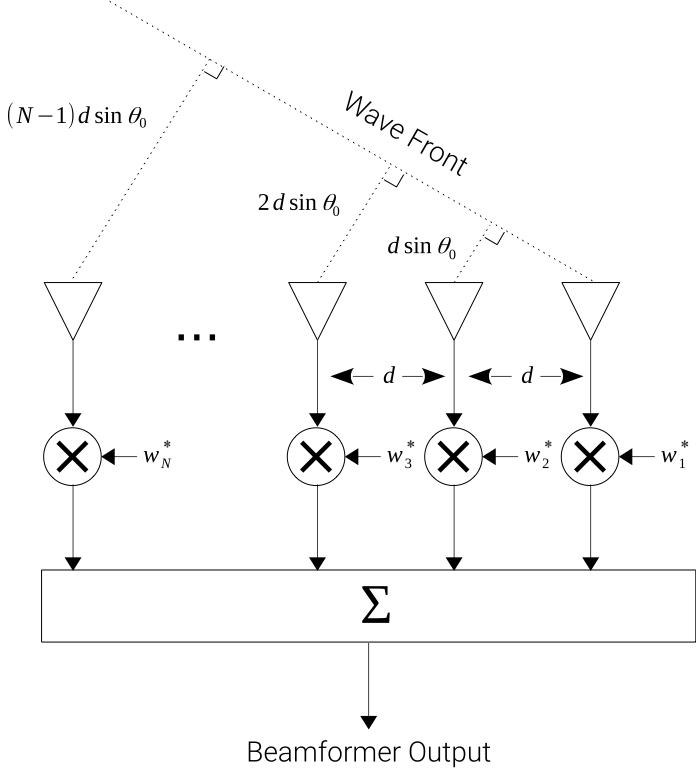

In [14]:
display(Image(filename='../../02_abf_background/ula_beamformer.png', width=400))

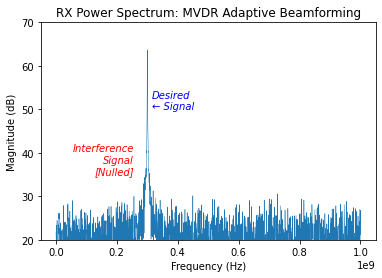

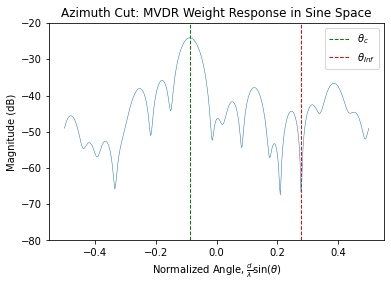

In [15]:
steer_vec = np.matrix(s).T
w_MVDR = MVDR_beamform( calc_covar_matrix(rx_all), steer_vec )
Y_MVDR = DBF_apply(rx_all, w_MVDR)

MVDR_PSD = 20*np.log10(np.abs(np.fft.fft(Y_MVDR)))
fig, ax = plt.subplots()
ax.plot(freqBin, MVDR_PSD, linewidth=0.5)
ax.set(xlabel='Frequency (Hz)',
       ylabel='Magnitude (dB)',
       title='RX Power Spectrum: MVDR Adaptive Beamforming')
ax.text(fInf*.95, 35, 'Interference\nSignal\n[Nulled]', horizontalalignment='right', color='red', fontstyle='italic')
ax.text(fc*1.05, 50, 'Desired\n← Signal', color='blue', fontstyle='italic')
ax.set_ylim([20, 70])
plt.show()

sin_mvdr = w_MVDR.H * wq
sin_mvdr = sin_mvdr.T
fig, ax = plt.subplots()
ax.plot(u*spacing, 20*np.log10(np.abs(sin_mvdr)), linewidth=0.5)
ax.set(xlabel=r'Normalized Angle, $\frac{d}{\lambda} \sin(\theta)$',
       ylabel='Magnitude (dB)',
       title='Azimuth Cut: MVDR Weight Response in Sine Space')
ax.set_ylim([-80, -20]) # set sensible magnitude limits since edges near 0 gain
# NOTE: since interference tone is at different frequency than desired tone,
#       the normalized sine space plot scales the incidence angles by its wavelength
ax.vlines(np.sin(np.deg2rad(theta))*spacing/wavelength, -80, -20, colors='green', linestyles='dashed', label=r'$\theta_{c}$', linewidth=1)
ax.vlines(np.sin(np.deg2rad(thetaInf))*spacing/wavelengthInf, -80, -20, colors='red', linestyles='dashed', label=r'$\theta_{Inf}$', linewidth=1)
ax.legend()
plt.show()

Here we can see that the off-angle interference wave is nulled out of the frequency response, yet the desired signal is at the same gain as the previous weighted-sum average spectrum.

### Multiple Interference Sources

The adaptive nulling scenario can be expanded to multiple sources of interference.

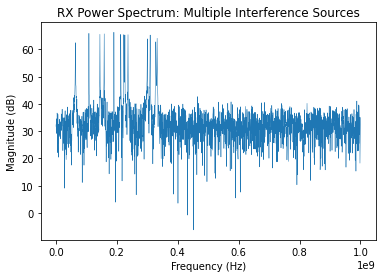

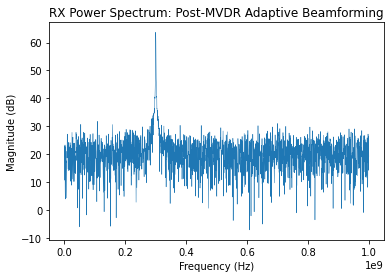

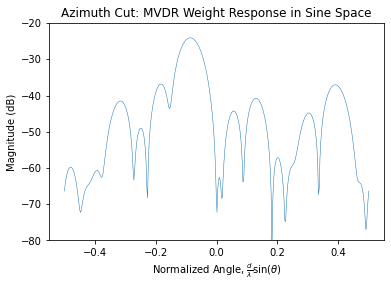

In [16]:
num_intfr = N - 4 # number of interference sources to add

# reuse desired signal & noise from before
rx_tmp   = rx_shft + infNoise
deg_step = 180.0/num_intfr # degree step to use for each interference source
for intfr_idx in range(num_intfr):
    inf_theta = -90.0 + (intfr_idx*deg_step)
    inf_fc    = random.uniform(0.05*fs, 0.5*fs)
    inf_wvlen = inf_fc/scipy.constants.c
    id_tmp    = narrowband_spatial_phasor(inf_wvlen, inf_theta, antPos)
    rx_tmp   += shifted_tone(np.sqrt(SNR*noiseP), inf_fc, t, id_tmp)

covar_MVDR = calc_covar_matrix(rx_tmp)
w_MVDR     = MVDR_beamform( covar_MVDR, steer_vec )
Y_MVDR     = DBF_apply(rx_tmp, w_MVDR)
    
test_PSD = 20*np.log10(np.abs(np.fft.fft(rx_tmp[6,:])))
fig, ax = plt.subplots()
ax.plot(freqBin, test_PSD, linewidth=0.5)
ax.set(xlabel='Frequency (Hz)',
       ylabel='Magnitude (dB)',
       title='RX Power Spectrum: Multiple Interference Sources')
plt.show()

test_MVDR_PSD = 20*np.log10(np.abs(np.fft.fft(Y_MVDR)))
fig, ax = plt.subplots()
ax.plot(freqBin, test_MVDR_PSD, linewidth=0.5)
ax.set(xlabel='Frequency (Hz)',
       ylabel='Magnitude (dB)',
       title='RX Power Spectrum: Post-MVDR Adaptive Beamforming')
plt.show()

sin_mvdr = w_MVDR.H * wq
sin_mvdr = sin_mvdr.T
fig, ax = plt.subplots()
ax.plot(u*spacing, 20*np.log10(np.abs(sin_mvdr)), linewidth=0.5)
ax.set(xlabel=r'Normalized Angle, $\frac{d}{\lambda} \sin(\theta)$',
       ylabel='Magnitude (dB)',
       title='Azimuth Cut: MVDR Weight Response in Sine Space')
ax.set_ylim([-80, -20]) # set sensible magnitude limits since edges near 0 gain
plt.show()

We can visualize the covariance matrix as a false color image, along with the deterministic steering vector on the last row; this corollary of the array input preprocessing (e.g. covariance matrix calculation) to 2D images makes an easier transition to interacting with our proposed Machine Learning (ML) model. Though an added dimension is added here to easily plot to standard `pyplot` utilities expecting three color channels (Red, Green, Blue), the input layer to the ML model can be of shape `(batch_size, N+1, N, 2)`, where the added `N+1` dimension allows us to include the intended steering vector, and the last dimension of `2` accounts for the real and imaginary parts of the complex sample covariance matrix.

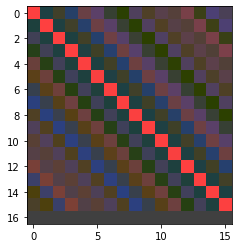

In [17]:
comb_re  = np.zeros((N+1,N))
comb_im  = np.zeros((N+1,N))
comb_re[:N, :] = covar_MVDR.real
comb_re[N, :]  = s.real
comb_im[:N, :] = covar_MVDR.imag
comb_im[N, :]  = s.imag
# create (N+1, N, 3) false color matrix for plotting covariance matrix & steering values
full_test = np.dstack((comb_re, np.zeros((N+1,N)), comb_im))
# normalize covariance values to 0-1 float range for proper plotting
ind_max   = np.unravel_index(np.argmax(full_test, axis=None), full_test.shape)
ind_min   = np.unravel_index(np.argmin(full_test, axis=None), full_test.shape)
full_test = (full_test + np.abs(full_test[ind_min]))/(full_test[ind_max] + np.abs(full_test[ind_min]))
plt.imshow(full_test)
plt.show()

## ML Beamforming


### Spatial Dataset Generation

The generated test data sets for training can be built using mathematical RF signal models to create realistic test data. Different parameters should vary to best train the CNN (as well as buck "overfitting" to a specific dataset/test) like:
* Number of interference sources (up to num_channels - 1 theoretical nulling limits)
* Desired & interference signal directions
* Desired & interference signal center frequencies
* Desired & interference signal SNRs
  + In Tim O'Shea's RadioML research, he built an interesting graph which was able to show model accuracy vs input SNR, where expectedly, very low SNR (or signals below noise) led to less probability of modulation classification (different application than us btw, though the RadioML dataset could be another interesting test source)
  + Maybe start to train w/high SNR first, then move to lower and lower SNR levels during training process
* [Advanced] Desired & interference signal modulation and bandwidths (e.x. simple AM/tone, QPSK, QAM, OFDM, LFM/chirp, etc.). This may be somewhat futile given we are generating narrowband weights.
 
Since we have lots of desired _features_ for our training data set, we could also explore using _dimensionality reduction_ algorithms in the future for feature extraction.

In [18]:
# using current ULA antenna setup, create a matrix of test scenarios
# vary frequency, direction
num_scenarios = 1 #128     # batch size of test dataset to generate
min_num_intfr = 0       # minimum number of interference sources (0 = no interference)
max_num_intfr = N - 2   # maximum number of interference sources (N-1 limit array can null)
min_az_deg    = -90     # minimum look angle (degrees)
max_az_deg    = 90      # maximum look angle (degrees)
min_fc        = 0.05*fs # minimum carrier frequency (Hz, based on given sample rate, fs)
max_fc        = 0.5*fs  # maximum carrier frequency (Hz, based on given sample rate, fs)

narrowband_test_set = 1j*np.zeros((num_scenarios,N,N)) # allocate dataset array (cmplx)
target_weight_lbls  = 1j*np.zeros((num_scenarios,N,1))   # allocate target beamforming weights
for samp_idx in range(num_scenarios):
    # first start w/additive gaussian noise (~0 dB)
    rx_tmp = (10.0**(-40.0/20.0))*(np.random.randn(N,M) + 1j*np.random.randn(N,M))
    
    num_intfr     = random.randint(min_num_intfr, max_num_intfr)
    desired_theta = random.uniform(min_az_deg, max_az_deg)
    desired_fc    = random.uniform(min_fc, max_fc)
    desired_wvlen = desired_fc/scipy.constants.c
    
    # add desired signal
    sd_tmp  = narrowband_spatial_phasor(desired_wvlen, desired_theta, antPos)
    d_SNR   = 20
    d_amp   = 10.0**((-65.0+d_SNR)/20.0)
    rx_tmp += shifted_tone(d_amp, desired_fc, t, sd_tmp)
    for intfr_idx in range(num_intfr):
        inf_theta = random.uniform(min_az_deg, max_az_deg)
        inf_fc    = random.uniform(min_fc, max_fc)
        inf_wvlen = inf_fc/scipy.constants.c
        id_tmp    = narrowband_spatial_phasor(inf_wvlen, inf_theta, antPos)
        rx_tmp   += shifted_tone(d_amp, inf_fc, t, id_tmp)
    sv = np.matrix(sd_tmp).T
    narrowband_test_set[samp_idx, :, :] = calc_covar_matrix(rx_tmp)
    target_weight_lbls[samp_idx, :] = MVDR_beamform( narrowband_test_set[samp_idx, :, :] , sv )


### CNN Design

I still want to build the covariance sample/estimation matrix on front end before the CNN;(its easy (HDL and implementation is fairly easy and not very resource heavey), and input layer is then pretty simple. For instance, instead of having to "window" a certain amount of data (say 1000 samples) for each channel as the input layer (which could be very resource heavy) an 8 channel system can have a 2D 8x8 input layer (8 channel rows x 8 covariance columns x 2 samples per I/Q) which should lead to much lighter overall resource usage (and easier training)
* The above input layer is not fully complete though, I also need to have some way to input the desired steering direction, perhaps as just a separate "channel"? (e.g. a 9x8 input layer for the 8 true channel case, where the extra row is the set of steering weights `d`, similar to how this vector is given in traditional QRD processes?). This should be OK since a CNN has no concept of what's what, the "magic" will be in training it anyways...
* I do also want to model some scenarios where I _don't_ have the covariance matrix on the front end, just to see how much larger the overall CNN becomes with the much wider input layer. Through training, the CNN might "come up" with a more efficient/better model anyways...
* Two other interesting input preprocessing should also be considered:
  - Using [STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (or overlapped/RTSA to get both time & frequency resolution) BUT instead of taking it across the temporal domain (e.g. across the time domain of each channel's samples like traditional FFT processing), we take it across the spatial dimension (e.g. across all channels, btw could process an 8-channel system with 8-pt FFT per sample, or larger FFT like 64-pt+ by stacking inputs?). We can make a good comparison to STFT used in audio/RF classification tasks (like TF's example and RadioML)
  - Investigate performance with input from [CWT, WVD or other time-frequency transform](https://www.mathworks.com/help/signal/ug/time-frequency-gallery.html#responsive_offcanvas)?
  - Investigate any other [Lossy Compression](https://en.wikipedia.org/wiki/Lossy_compression) preprocessing methods, like [DCT](https://en.wikipedia.org/wiki/Discrete_cosine_transform) or [DWT](https://en.wikipedia.org/wiki/Discrete_wavelet_transform), which can create compressed 2D input layers?

The output layer should be 2D for complex weights (N channels x 2 per I/Q weight), since the goal is to have a CNN which can directly create weights for beamforming "weight and sum"/MAC application in PL logic.

In [19]:
# look at https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
# for how to map dataset
model = models.Sequential([
    layers.Flatten(input_shape=(N, N)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(N*2)
])

# http://d2l.ai/chapter_convolutional-neural-networks/lenet.html
# and simple_audio.ipynb
#model = models.Sequential([
#    layers.Input(shape=rf_test.shape),
#    layers.Conv2D(32, 3, activation='relu'),
#    layers.Conv2D(64, 3, activation='relu'),
#    layers.MaxPooling2D(),
#    layers.Dropout(0.25),
#    layers.Flatten(),
#    layers.Dense(128, activation='relu'),
#    layers.Dropout(0.5),
#    layers.Dense(N*2),
#])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
Total params: 37,024
Trainable params: 37,024
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

---

## Notes/`TODO`:
  + For documentation comparison of ML results (besides implementation performance in real PL fabric- hopefully its smaller/faster!), compare "performance" (SINR) of ML model to full SMI, MVDR (the perfect case doing sample inversion on entire dataset).
  + At the end of creating floating-point model in TensorFlow, the extra quantization tools (which are used for embedded targets like TF Lite) should output a fixed point model for comparison as well (since this would be easiest/most resource optimized for FPGA logic implementation)
    * Full FP32 model is still useful though as we could use HLS tools like Xilinx Vitis AI and hls4ml to create PL blocks for resource/performance comparison.

 ## References
 
 
[1] Van Trees, H.L. _Optimum Array Processing_. New York, NY: Wiley-Interscience, 2002.

[2] Guerci, J.R. _Space-Time Adaptive Processing for Radar_, 2nd ed. Boston, MA: Artech House, 2015.